# CityStreetFlow: QUBO-ML Traffic Optimization

In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import re
import pandas as pd
import torch 
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import dimod
import dynex
from tqdm.notebook import tqdm
import json
import warnings
warnings.filterwarnings("ignore")

### Loading/Analyzing district using [OSM] OpenStreetMap

In [2]:
def parse_speed_limit(speed_limit):
    match = re.search(r'\d+', speed_limit)
    if match:
        return int(match.group())  
    return None  

def ExtractInfo(graph, edgeColors):
    junctionNodes = []
    df = pd.DataFrame(columns=["RoadType", "SpeedLimit", "NodeID", "x", "y"])
    for u, v, k, data in graph.edges(keys=True, data=True):
        if 'highway' in data:
            roadType = data['highway'][0] if isinstance(data['highway'], list) else data['highway']
            speedLimit = data.get('maxspeed', 'No data')
            if isinstance(speedLimit, list):
                speedLimit = speedLimit[0]
            if 'mph' in speedLimit or isinstance(speedLimit, str) and speedLimit.isdigit():
                speedLimit = parse_speed_limit(speedLimit)
            for _, _, d in graph.out_edges(u, data=True):
                neighborRoadType = d['highway'][0] if isinstance(d['highway'], list) else d['highway']
                if neighborRoadType != roadType and u not in [node[0] for node in junctionNodes]:
                    junctionNodes.append((u, roadType, speedLimit))
                    new_row = pd.DataFrame({
                        "RoadType": [roadType],
                        "SpeedLimit": [speedLimit],
                        "NodeID": [u],
                        "x": [graph.nodes[u]['x']],
                        "y": [graph.nodes[u]['y']]
                    })
                    df = pd.concat([df, new_row], ignore_index=True)
            for _, _, d in graph.out_edges(v, data=True):
                neighborRoadType = d['highway'][0] if isinstance(d['highway'], list) else d['highway']
                if neighborRoadType != roadType and v not in [node[0] for node in junctionNodes]:
                    junctionNodes.append((v, roadType, speedLimit))
                    new_row = pd.DataFrame({
                        "RoadType": [roadType],
                        "SpeedLimit": [speedLimit],
                        "NodeID": [v],
                        "x": [graph.nodes[v]['x']],
                        "y": [graph.nodes[v]['y']]
                    })
                    df = pd.concat([df, new_row], ignore_index=True)
    df.to_csv('speedLimit_.csv', index=False)
    return junctionNodes

def LoadPlot(placeName):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") #I'm using old version of OSM API, even though I couldn't disable all warnings lol
        fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
        ax.set_facecolor('white')
        graph = ox.graph_from_place(placeName)
        buildings = ox.geometries_from_place(placeName, tags={'building': True})
        plots = ox.features_from_place(placeName, tags={'landuse': True})
        
        edgeColors = {
            'motorway': 'red',
            'primary': 'orange',
            'secondary': 'yellow'} # you can include all road types, but this example is just a showcase
        for u, v, k, data in graph.edges(keys=True, data=True):
            if 'highway' in data:
                roadType = data['highway'][0] if isinstance(data['highway'], list) else data['highway']
                color = edgeColors.get(roadType, 'gray')
                x1, y1 = graph.nodes[u]['x'], graph.nodes[u]['y']
                x2, y2 = graph.nodes[v]['x'], graph.nodes[v]['y']
                ax.plot([x1, x2], [y1, y2], color=color, linewidth=1, alpha=0.8)        
        buildings.plot(ax=ax, facecolor='khaki', alpha=1.0)
        plots.plot(ax=ax, facecolor='green', alpha=0.5)
        junctionNodes = ExtractInfo(graph, edgeColors)
        for node, roadType, speedLimit in junctionNodes:
            color = 'aqua' if speedLimit == 'No data' else ('red' if int(speedLimit) >= 40 else 'purple')
            ax.scatter(graph.nodes[node]['x'], graph.nodes[node]['y'], c=color, s=20, zorder=3)
        legendElements = [
            mlines.Line2D([], [], color='orange', label='Primary Road'),
            mlines.Line2D([], [], color='yellow', label='Secondary Road'),
            mlines.Line2D([], [], color='gray', label='OtherRoads/Ave'),
            mlines.Line2D([], [], color='khaki', label='Buildings', linewidth=10),
            mlines.Line2D([], [], color='green', label='Plots', linewidth=10),
            mlines.Line2D([], [], color='red', marker='o', markersize=5, label='Junctions (SPEED >=40)', linewidth=0),
            mlines.Line2D([], [], color='purple', marker='o', markersize=5, label='Junctions (SPEED <40)', linewidth=0),
            mlines.Line2D([], [], color='aqua', marker='o', markersize=5, label='Cycleway/Pedestrian', linewidth=0)
        ]
        ax.legend(handles=legendElements, loc='upper left')
        plt.show()
    return graph

#### [NOTE]: this is a heavy processing phase, it may take up to 5 minutes
#### [WARNING]: if you try to load a whole city, then you need at least over 1GB memory

/tmp/ipykernel_59786/818263979.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


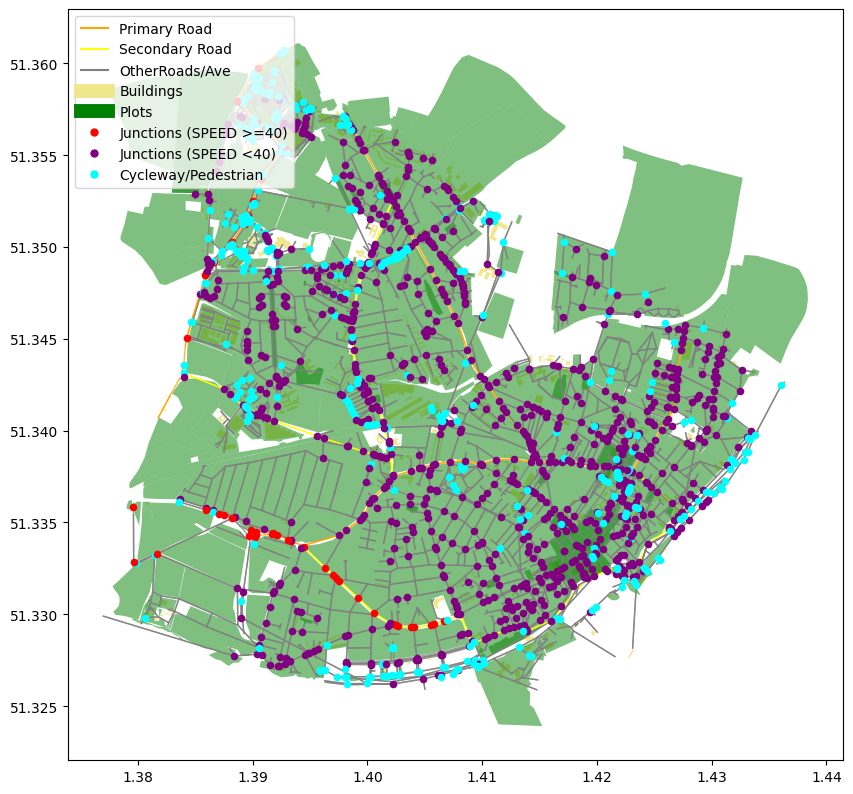

In [3]:
# "District/Area, City, Country"
#placeName = "City of London, London, England, UK" 
placeName = "Ramsgate, Kent, UK"
graph = LoadPlot(placeName)

### Calculating Traffic Stress based on specific weights

In [4]:
def CalculateStress(edgeData, weights):
    roadType = edgeData['highway']
    if isinstance(roadType, list):
        roadType = roadType[0]
    stressLevel = weights['roadType'].get(roadType, 0)
    speedLimit = edgeData.get('maxspeed', 'No data')
    if isinstance(speedLimit, list):
        speedLimit = speedLimit[0]  
    try:
        speedLimit = int(speedLimit)
        if speedLimit > 50:
            stressLevel += weights['speedLimit']
    except ValueError:
        pass  # speedLimit is not a number which means "no data" which means also it's either cycleways/footways/pedestrian
    return stressLevel

def ApplyStressToGraph(graph, weights):
    for u, v, k, data in graph.edges(data=True, keys=True):
        data['stress'] = CalculateStress(data, weights)
    return graph


weights = {
    'roadType': {
        'motorway': 10,
        'primary': 5,
        'secondary': 3,
        'tertiary': 3,
        'cycleway': 0,
        'footway': 0,
        'residential': 3,
    },
    'speedLimit': 5}

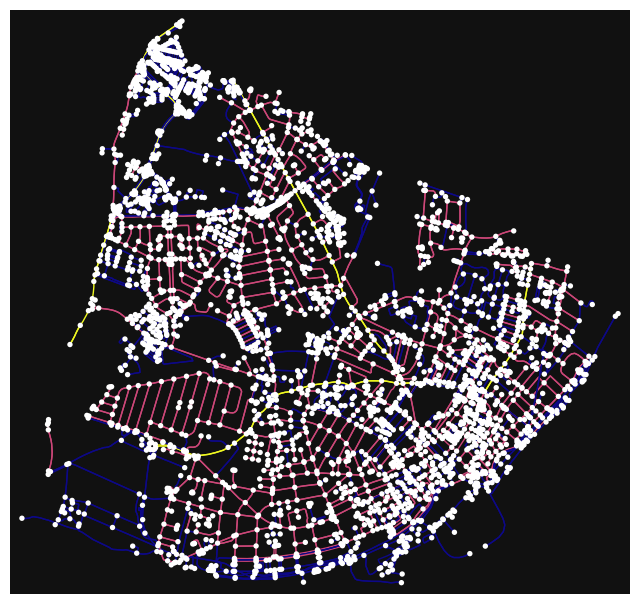

In [5]:
graph = ApplyStressToGraph(graph, weights)
ec = ox.plot.get_edge_colors_by_attr(graph, 'stress', cmap='plasma', num_bins=5)
fig, ax = ox.plot_graph(graph, edge_color=ec)

### Find the optimal nodes positioning by Minimizing Stress & Prioritizing Compactness

E=A∑ i​ (p i​−P i​)2+B∑j​(sj​−Sj​)2+C∑i,j​pi​sj​Dij​
 

Here:

A,B,C: Weights to control the importance of different terms.

Pi​: Desired or optimal positioning of nodes (may depend on external factors).

Sj​ : Desired or optimal speed limit (may depend on external factors).

Dij​: Matrix representing the impact of placing a node at position i on a road segment with speed limit j

In [6]:
def ConstructQuboModel(graph, weights, aWeight, bWeight, distanceThreshold=None, stressThreshold=None):
    nodeCoordsData = [(node, data['x'], data['y']) for node, data in graph.nodes(data=True)]
    edgeStressData = [(u, v, data['stress']) for u, v, data in graph.edges(data=True)]
    linearTerms = {
        node: aWeight * sum(data for u, v, data in edgeStressData if u == node or v == node)
        for node, x, y in nodeCoordsData}
    quadraticTerms = {}
    for (nodeI, xI, yI) in nodeCoordsData:
        for (nodeJ, xJ, yJ) in nodeCoordsData:
            if nodeI != nodeJ:
                distance = np.linalg.norm(np.array((xI, yI)) - np.array((xJ, yJ)))
                if (distanceThreshold is None or distance <= distanceThreshold) and \
                   (stressThreshold is None or (linearTerms[nodeI] > stressThreshold and linearTerms[nodeJ] > stressThreshold)):
                    quadraticTerms[(nodeI, nodeJ)] = bWeight * linearTerms[nodeI] * linearTerms[nodeJ] * distance
    #print(quadraticTerms)
    #print(linearTerms)
    #saveTermsToFile(linearTerms, "linearTerms.txt") # Just for Testing & Debugging
    #saveTermsToFile(quadraticTerms, "quadraticTerms.txt") # Just for Testing & Debugging
    
    bqm = dimod.BinaryQuadraticModel(linearTerms, quadraticTerms, offset=0.0, vartype=dimod.BINARY)
    
    return bqm
    
def sampleQuboSolution(bqm):
    sampler = dimod.SimulatedAnnealingSampler()
    sampleset = sampler.sample(bqm, num_reads=1)
    return sampleset.first.sample

def dynexQuboSolution(bqm):
    model = dynex.BQM(bqm)
    sampler = dynex.DynexSampler(model, mainnet=False, description='Street Traffic Optimizer', bnb=False)
    sampleset = sampler.sample(num_reads=100, annealing_time = 100, debugging=False);
    return sampleset.first.sample;

def saveTermsToFile(terms, filename):
    strTerms = {str(key): value for key, value in terms.items()}
    with open(filename, "w") as file:
        json.dump(strTerms, file)

In [7]:
# This could take up to 60 sec
a, b = 10.0, 1.0
## [DANGER ZONE]: now since we are analyzing all different type of roads (junctionNodes), quadratic terms become more
## and more complex and may end up with terms that are larger than 500 MB. 
## so I had to make some conditions to minimize these terms.(OPTIONAL)
## if you want the whole quadratic terms just assign "None" to [distanceThreshold,stressThreshold]

distanceThreshold = 1000  # Maximum distance between nodes to create a quadratic term (m)
stressThreshold = 5       # Minimum stress level for nodes to be included in quadratic terms (checkWeights)
bqm = ConstructQuboModel(graph, weights, a, b, distanceThreshold, stressThreshold)
# bqm2 = constructQuboModel(graph, weights, aWeight2, bWeight2)

if you want to test running this QUBO model on your PC/Server, then execute the cell below

[INFO]: This could take up to 140 sec for just 1 num_reads

#### Compute using DYNEX

In [8]:
sampleset = dynexQuboSolution(bqm)

[DYNEX] SAMPLER INITIALISED
[DYNEX|TESTNET] *** WAITING FOR READS ***
╭────────────┬──────────┬─────────────────┬─────────────┬───────────┬───────────────────────────┬────────────┬─────────┬────────────────╮
│   DYNEXJOB │   QUBITS │   QUANTUM GATES │   BLOCK FEE │ ELAPSED   │ WORKERS READ              │ CIRCUITS   │ STEPS   │ GROUND STATE   │
├────────────┼──────────┼─────────────────┼─────────────┼───────────┼───────────────────────────┼────────────┼─────────┼────────────────┤
│         -1 │     3446 │         1567343 │           0 │           │ *** WAITING FOR READS *** │            │         │                │
╰────────────┴──────────┴─────────────────┴─────────────┴───────────┴───────────────────────────┴────────────┴─────────┴────────────────╯

[DYNEX] FINISHED READ AFTER 0.29 SECONDS
[DYNEX] SAMPLESET READY


### Visualize the Optimal Nodes Positioning

In [9]:
def validateNodes(graph, sampleset):
    pos = {node: (data['x'], data['y']) for node, data in graph.nodes(data=True)}
    optimalNodes = [node for node, position in sampleset.items() if position == 1]
    for node in optimalNodes:
        if node not in pos:
            print(f"Node {node} does not have a position in the graph.")
        else:
            print(f"Node {node} is at position {pos[node]} in the graph.")
    return pos, optimalNodes
#pos, optimalNodes = validateNodes(graph, sampleset)

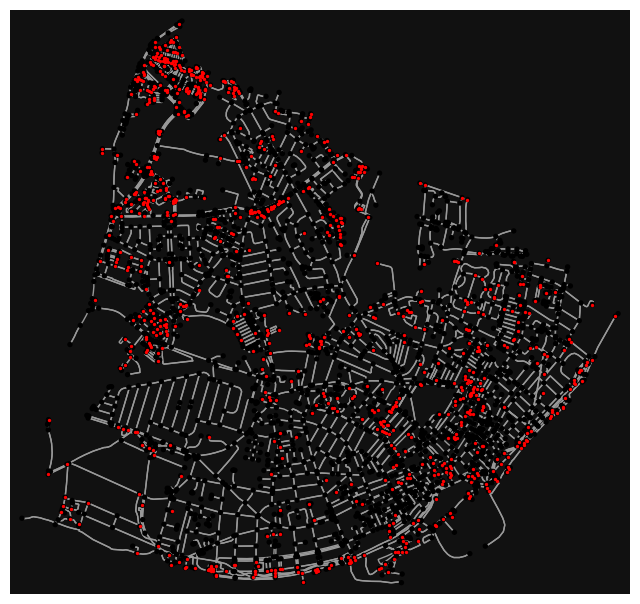

In [10]:
def OptimalNodePositioning(graph, sampleset):
    junctionNodes = [node for node, position in sampleset.items() if position == 1]
    fig, ax = ox.plot_graph(graph, node_color='black', show=False, close=False)
    junctionNodeCoords = [(data['x'], data['y']) for node, data in graph.nodes(data=True) if node in junctionNodes]
    for coord in junctionNodeCoords:
        ax.scatter(coord[0], coord[1], c='red', s=2, zorder=3)
    plt.show()
    
OptimalNodePositioning(graph, sampleset)

Now based on the optimal new nodes, we can suggest/create new roads BUT you must consider these factors:
- **GIS software**: if we want to implement this example in real-world case, we must collect all the realtime data using GIS software
- **Infrastructure**: in Urban planning, we need to have analyze the inftastructure of the city so that we can create/eliminate roads
- **Urban Planning Principles**: connectivity, avoiding creation of too many intersections, etc.
- **Legal and Environmental Constraints**

but nevertheless, this is an educational use case, and it can easily modified for real-world factors

In [11]:
def NewRoads(graph, sampleset, maxDistance=500, newRoads=10):
    junctionNodes = [node for node, position in sampleset.items() if position == 1]
    potentialNewRoads = []
    for i, node1 in enumerate(junctionNodes):
        x1, y1 = graph.nodes[node1]['x'], graph.nodes[node1]['y']
        for j, node2 in enumerate(junctionNodes):
            if i < j: 
                x2, y2 = graph.nodes[node2]['x'], graph.nodes[node2]['y']
                distance = np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
                if distance < maxDistance: # for example
                    potentialNewRoads.append((node1, node2, distance))
    potentialNewRoads.sort(key=lambda x: x[2])
    selectedNewRoads = potentialNewRoads[:newRoads] # also for example
    for node1, node2, distance in selectedNewRoads:
        newRoadAttributes = {
            'osmid': -1,  # since I don't know all the OSM IDs
            'highway': 'residential', # also for example :)
            'length': distance,  # replace with actual length if available
            'speed_limit': 30  # replace with actual speed limit if available
        }
        graph.add_edge(node1, node2, **newRoadAttributes)
    return graph

In [12]:
#NewRoads(graph, sampleset) # I have better way but I'm still working on it

### Predicting the new SpeedLimits for the Optimal Nodes Positioning [new nodes]

I know I can come up with better model and more efficient and I apologize for that :\ 
    but I will work on it definitely when I'm little bit less busy :)

#### Data preparation

In [13]:
df = pd.read_csv('speedLimit_.csv')
df['SpeedLimit'] = pd.to_numeric(df['SpeedLimit'], errors='coerce')
df = df.dropna(subset=['SpeedLimit'])
scaler = StandardScaler()
df[['x', 'y']] = scaler.fit_transform(df[['x', 'y']])
train, test = train_test_split(df, test_size=0.2, random_state=42)
trainX = torch.Tensor(train[['x', 'y']].values)
trainY = torch.Tensor(train['SpeedLimit'].values).view(-1, 1)
testX = torch.Tensor(test[['x', 'y']].values)
testY = torch.Tensor(test['SpeedLimit'].values).view(-1, 1)

def augmentation(x, noiseF=0.01):
    noise = noiseF * torch.randn(x.size())
    augmentation = x + noise
    return augmentation

#### Initialize the NN model

In [14]:
class SPnet(nn.Module):
    def __init__(self):
        super(SPnet, self).__init__()
        self.fc1 = nn.Linear(2, 64) 
        self.fc2 = nn.Linear(64, 1) 
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = SPnet()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
batch_size = 64
trainDataset = TensorDataset(trainX, trainY)
trainLoader = DataLoader(dataset=trainDataset, batch_size=batch_size, shuffle=True)
trainL = []
testL = []

#### Number of epochs

In [15]:
num_epochs = 5000
noiseF = 0.01  

#### Training

In [16]:
pbar = tqdm(range(num_epochs), desc='Epochs')
for epoch in pbar:
    model.train()
    epochTL = 0.0
    
    for batchX, batchY in trainLoader:  
        augBX = augmentation(batchX, noiseF)
        optimizer.zero_grad()
        outputs = model(augBX)
        loss = criterion(outputs, batchY)
        loss.backward()
        optimizer.step()
        epochTL += loss.item() / len(trainLoader)
        
    model.eval()
    with torch.no_grad():
        outputsT = model(testX)
        val_loss = criterion(outputsT, testY)
    trainL.append(epochTL)
    testL.append(val_loss.item())
    pbar.set_postfix({'Train Loss': f'{epochTL:.4f}', 'Validation Loss': f'{val_loss.item():.4f}'})

Epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

#### Predict the new SpeedLimits based on the Optimal Nodes Positioning

In [17]:
optimalNodes = [node for node, position in sampleset.items() if position == 1]

nCoords = pd.DataFrame({
    'node': optimalNodes,
    'x': [graph.nodes[node]['x'] for node in optimalNodes],
    'y': [graph.nodes[node]['y'] for node in optimalNodes]
})

# Normalize the x, y coordinates using the same scaler used during training
optimalNodesNorms = torch.Tensor(scaler.transform(nCoords[['x', 'y']]))


model.eval()

with torch.no_grad():
    newSpeedLimits = model(optimalNodesNorms)
    
newSpeedLimits = newSpeedLimits.numpy().flatten().round().astype(int)
dic = dict(zip(optimalNodes, newSpeedLimits))
print(dic)

{423418: 54, 29028390: 32, 29028421: 31, 29028434: 31, 29028438: 30, 29028725: 31, 29029250: 33, 29029423: 31, 29029440: 31, 29029444: 31, 29029471: 30, 29029497: 31, 29029498: 31, 29030278: 31, 29033166: 31, 29034674: 30, 29058265: 30, 29058272: 31, 29783156: 50, 29799014: 48, 29950644: 33, 29950650: 34, 29961868: 31, 36495228: 29, 36495229: 32, 177344815: 40, 300393969: 33, 300393971: 35, 300393978: 21, 300393999: 21, 300604497: 30, 300612692: 32, 300615150: 39, 300628206: 30, 300628217: 31, 300628470: 31, 300649167: 31, 300697286: 30, 300697312: 31, 300697350: 30, 300697409: 31, 300697429: 30, 300698981: 26, 300698988: 28, 300698991: 28, 300700020: 31, 300708668: 26, 300708674: 26, 300708676: 27, 300716698: 31, 300716702: 31, 300919947: 31, 300925063: 31, 300925065: 31, 300925088: 31, 300925096: 31, 300925108: 31, 300926688: 31, 300935058: 31, 300946883: 31, 307449022: 25, 307458810: 25, 307458877: 25, 307458894: 27, 307461849: 24, 307461853: 24, 307461868: 25, 307493592: 31, 308282

### Visualize the Optimal Nodes with Predicted SpeedLimits

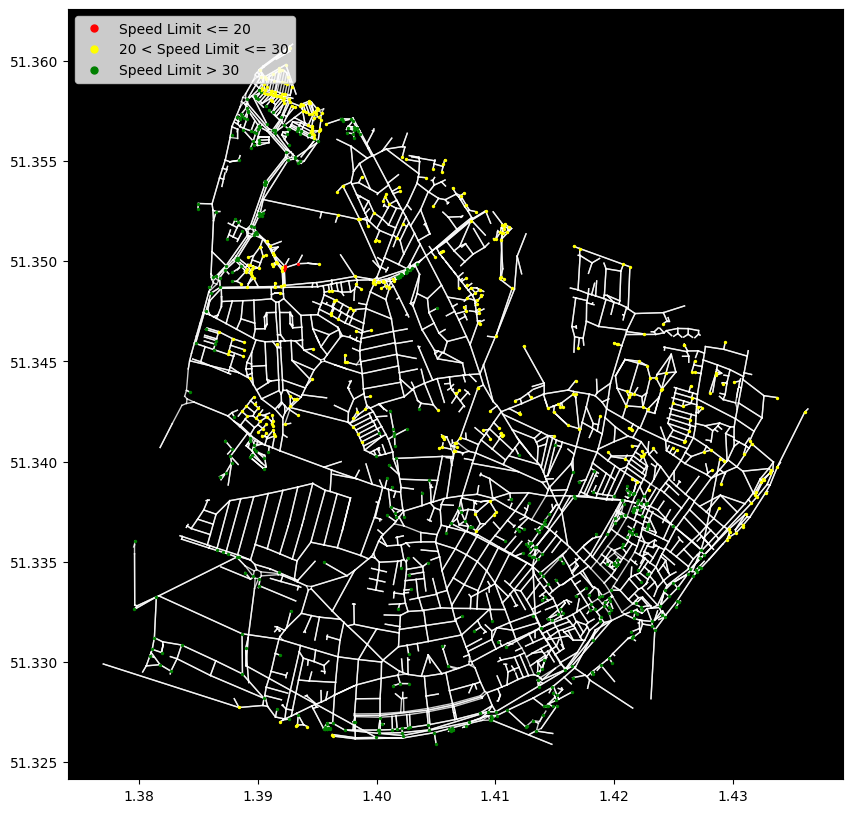

In [18]:
def visualizeSpeedLwONoes(graph, speedLimits, sampleset):
    pos = {node: (data['x'], data['y']) for node, data in graph.nodes(data=True)}
    optimalNodes = [node for node, position in sampleset.items() if position == 1]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_facecolor('black')
    for u, v, k, data in graph.edges(keys=True, data=True):
        x1, y1 = graph.nodes[u]['x'], graph.nodes[u]['y']
        x2, y2 = graph.nodes[v]['x'], graph.nodes[v]['y']
        ax.plot([x1, x2], [y1, y2], color='white', linewidth=1, alpha=0.8)
    for node in optimalNodes:
        if node in speedLimits and node in pos:
            speedLimit = speedLimits[node]
            if speedLimit <= 20:
                color = 'red'
            elif 20 < speedLimit <= 30:
                color = 'yellow'
            else:
                color = 'green'
            ax.scatter(pos[node][0], pos[node][1], c=color, s=2, zorder=3)
    legendElements = [
        mlines.Line2D([], [], color='red', marker='o', markersize=5, label='Speed Limit <= 20', linewidth=0),
        mlines.Line2D([], [], color='yellow', marker='o', markersize=5, label='20 < Speed Limit <= 30', linewidth=0),
        mlines.Line2D([], [], color='green', marker='o', markersize=5, label='Speed Limit > 30', linewidth=0)
    ]
    ax.legend(handles=legendElements, loc='upper left')
    plt.axis('on')
    plt.show()
visualizeSpeedLwONoes(graph, dic, sampleset)

# ------------------------------------------------------------------------------------------

## EasterEgg [E45T3R3GG] (Optional):

I taught the machine some secret things that shouldn't be revealed lol
but DO NOT make it give you more than 43 secret letters or else....

#### Initialize the ANN and load the pre-trained model

In [19]:
def E45T3R3GG(secretLetters):
    class SamSecretModel(nn.Module):
        def __init__(self):
            super(SamSecretModel, self).__init__()
            self.layers = nn.Sequential(
                nn.Linear(1, 256),
                nn.ReLU(),
                nn.Linear(256, 512),
                nn.ReLU(),
                nn.Linear(512, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 1))
        def forward(self, x):
            return self.layers(x)
    model = SamSecretModel()
    model.load_state_dict(torch.load('E45T3R3GG.pth'))
    model.eval()
    x = np.array(list(range(secretLetters)), dtype=np.float32).reshape(-1, 1)
    xsc = (x - 0.0) / (288.0 - 0.0)  
    xT = torch.from_numpy(xsc).float()
    yT = model(xT)
    y = np.round(yT.detach().numpy() * (35.0 - 0.0) + 0.0).astype(int)
    magic = y.flatten().tolist()
    uN = [10609, 19321, 21025, 25600, 26569, 32761, 44521, 49729, 51076, 61009, 64009, 65536,
                           71824, 88804, 90601, 92416, 94249, 96100, 97969, 99856, 101761, 103684, 107584, 109561,
                           111556, 113569, 115600, 117649, 121801, 123904, 126025, 128164, 130321, 132496, 134689, 136900]
    sMessage = ''.join([chr(int((uN[i] ** 0.5) - 7) // 3) for i in magic])
    print(sMessage)

#### Execute the E45T3R3GG

In [20]:
secretLetters = 43              # Keep it 43 to reveal the secret letters :D
E45T3R3GG(secretLetters)    

Happy anniversary Dynex :P, from Sam Rahmeh
